# Banana Collector with DQN

### 1. Setup the Environment
This notebook implements Banana Collector Agent within Udacity provided environment. We begin by importing necessary packages such as Unity, numpy, torch, etc.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size_env = brain.vector_action_space_size
print('Number of actions:', action_size_env)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size_env = len(state)
print('States have length:', state_size_env)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train the Agent

Next code cell implements and runs the main training loop of the DQN agent called train_dqn(). DQN agent is implemented in the dqn_agent.py so we need to import the agent implementation first. Then we instantiate the agent with the state size and action size obtained from the environment.

Once agent is instantiated, we can run the training loop implemented in the train_dqn() which takes four arguments. These arguments are maximum number of episodes during training, maximum number of timesteps in each episode, maximum and minimum epsilon used for epsilon-greedy action selection and epsilon decay factor.

Within the training loop, agent.act() selects the action based on its current state-action values using epsilon-greedy action selection. env.step() sends the selection action to the environment and gets back the new environment state along with reward. Then agent.step() updates its' DQN network given the new state and reward information. 

Environment is considered to be solved when average score of past 100 episodes is equal or greater than 15. At this point, torch saves the deep network model weights.

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.0)
)
Episode 100	Average Score: 0.61
Episode 200	Average Score: 3.02
Episode 300	Average Score: 6.51
Episode 400	Average Score: 9.00
Episode 500	Average Score: 12.33
Episode 600	Average Score: 13.36
Episode 700	Average Score: 14.27
Episode 736	Average Score: 15.02
Environment solved in 636 episodes!	Average Score: 15.02


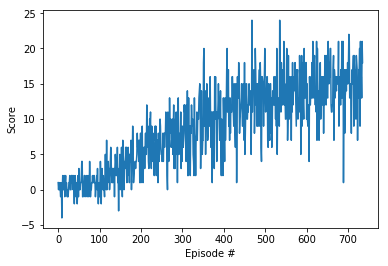

In [5]:
from dqn_agent import Agent

agent = Agent(state_size=state_size_env, action_size=action_size_env, seed=0)

def train_dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished 
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state
            
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=15.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))

            checkpoint = {'input_size': agent.state_size,
              'output_size': agent.action_size,
              'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
              'state_dict': agent.qnetwork_local.state_dict()}
        
            torch.save(checkpoint, 'checkpoint_{}.pth'.format(i_episode))

            break
    return scores

scores = train_dqn()


checkpoint = {'input_size': agent.state_size,
              'output_size': agent.action_size,
              'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
              'state_dict': agent.qnetwork_local.state_dict()}
        
torch.save(checkpoint, 'checkpoint_last.pth')


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('AverageScore.png')

### 4. Run the Trained Agent

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [11]:
agent = Agent(chkpt_file="checkpoint_last.pth", seed=0)

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0.01)                      # agent selects an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.0)
)
Score: 13.0


When finished, you can close the environment.

In [12]:
env.close()